### Import Package

In [ ]:
!pip install -q stockstats

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from stockstats import StockDataFrame

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.svm import SVC

from math import floor

import pandas_datareader.data as web
import pickle
import time
import warnings
warnings.filterwarnings('ignore')

# Load Stock Data

In [ ]:
start_date = "2000-01-01"
end_date = "2022-12-31"
stock_data = web.DataReader('FB', 'stooq',start=start_date, end=end_date)
stock_data.columns = ["open","high","low","close","volume"]

In [ ]:
# Use online package to generate additional features
x = StockDataFrame(stock_data)
data = x[['open','high','low','close','volume',
          'boll', 'boll_ub', 'boll_lb',
          'macd', 'macdh', 'macds',
          'rsi_11', 'rsi_14', 'rsi_21']]
data.index = [int(str(ind)[0:4]+str(ind)[5:7]+str(ind)[8:10]) for ind in data.index]
data = data.sort_index()

In [ ]:
data

,open,high,low,close,volume,boll,boll_ub,boll_lb,macd,macdh,macds,rsi_11,rsi_14,rsi_21
20120518,42.050,45.0000,38.00,38.23,580438450,29.375500,35.683208,23.067792,1.391935,0.897354,0.494581,74.776198,72.187020,68.646294
20120521,36.530,36.6600,33.00,34.03,169418988,29.034500,33.898990,24.170010,0.848359,0.578117,0.270243,66.227384,64.371764,62.210613
20120522,32.610,33.5900,30.94,31.00,101876406,28.928500,33.412137,24.444863,0.569855,0.444142,0.125713,56.574965,56.110066,56.006192
20120523,31.370,32.5000,31.36,32.00,73678512,28.958500,33.508041,24.408959,0.514603,0.499925,0.014678,61.881312,60.402489,59.053713
20120524,32.950,33.2100,31.77,33.03,42560731,28.950500,33.478032,24.422968,0.334778,0.445081,-0.110303,67.839265,65.170832,62.383596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20220418,210.000,213.3800,208.30,210.77,16580792,200.136000,228.605807,171.666193,1.417343,0.583317,0.834026,81.354966,81.854953,82.442164
20220419,210.520,218.4299,209.00,217.31,20089871,197.477500,227.347830,167.607170,1.279091,0.692066,0.587025,100.000000,100.000000,100.000000
20220420,213.605,214.1600,198.92,200.42,43036528,190.866667,207.880782,173.852551,0.496180,0.263698,0.232483,100.000000,100.000000,100.000000
20220421,201.600,202.9650,185.58,188.07,49954078,186.090000,191.690286,180.489714,0.088846,0.039487,0.049359,100.000000,100.000000,100.000000


# Data Preprocessing

### Split the train and test data

In [ ]:
# Split the train and test data

def custom_split(data,start,end):
    train = (data.index >= start) & (data.index <= end)
    train_X = data[train]
    
    return train_X

In [ ]:
train_X = custom_split(data,start = 20130101,end = 20171031)
valid_X = custom_split(data,start = 20171101,end = 20181231)
test_X = custom_split(data,start = 20190101,end = 20201231)

### Label the target result (opening price on 6th day)

In [ ]:
# Assume we use 5 days price data to predict closing price of the 6th day
num_day_to_predict = 5


In [ ]:
def produce_result_target_price(X,num_day,result_col_name = "result_price"):
    y = pd.DataFrame(np.nan, index=X.index, columns=[result_col_name])
    for i in range(num_day,len(X)):
        y.loc[X.index[i-1],result_col_name] = X.loc[X.index[i],"open"]
    
    return y

In [ ]:
train_y = produce_result_target_price(train_X,num_day_to_predict)
valid_y = produce_result_target_price(valid_X,num_day_to_predict)
test_y = produce_result_target_price(test_X,num_day_to_predict)

### Transform the -day data into one vector

In [ ]:
def transform_x_data_to_one_vector(X,num_day):
    col_name = []
    for i in range(num_day):
        for j in X.columns:
            col_name.append(j+"-"+str(i))
    new_X = pd.DataFrame(np.nan, index=X.index, columns=col_name)
    
    for i in range(num_day-1,len(X)):
        for col in col_name:
            split_list = col.split("-")
            new_X.loc[X.index[i],col] = X.loc[X.index[i-int(split_list[1])],split_list[0]]
    
    return new_X

In [ ]:
train_X_5 = transform_x_data_to_one_vector(train_X,num_day_to_predict)
valid_X_5 = transform_x_data_to_one_vector(valid_X,num_day_to_predict)
test_X_5 = transform_x_data_to_one_vector(test_X,num_day_to_predict)

### Drop out rows with NaN

In [ ]:
def drop_nan_row_y(y,num_day):
    drop_list = [y.index[i] for i in range(num_day)]
    drop_list.append(y.index[-1])
    return y.drop(drop_list)

def drop_nan_row_X(X,num_day):
    drop_list = [X.index[i] for i in range(num_day)]
    drop_list.append(X.index[-1])
    return X.drop(drop_list)

In [ ]:
new_train_X_5 = drop_nan_row_X(train_X_5,num_day_to_predict)
new_train_y = drop_nan_row_y(train_y,num_day_to_predict)

new_valid_X_5  = drop_nan_row_X(valid_X_5,num_day_to_predict)
new_valid_y = drop_nan_row_y(valid_y,num_day_to_predict)

new_test_X_5  = drop_nan_row_X(test_X_5,num_day_to_predict)
new_test_y = drop_nan_row_y(test_y,num_day_to_predict)




## Data Labelling

In [ ]:
def get_label_for_svm(X,y):
    cols = []
    for col in X.columns:
        if "open-" in col:
            cols.append(col)
    X = X[cols]
    X["mean"] = X.mean(axis=1)
    y_ser = y.iloc[:,0]
    x_ser = X.loc[:,"mean"]
    compare = (y_ser > x_ser).to_list()
    action = list(map(lambda ele: 1 if ele else 0,compare)) # 1: Buy | 0: Sell
    return pd.Series(action, name = "Action")
    

In [ ]:
new_action_train_y = get_label_for_svm(new_train_X_5,new_train_y)
new_action_valid_y = get_label_for_svm(new_valid_X_5,new_valid_y)
new_action_test_y = get_label_for_svm(new_test_X_5,new_test_y)

In [ ]:
# Keep a copy for reverting prediction result
old_train_X_5 = new_train_X_5
old_valid_X_5 = new_valid_X_5
old_test_X_5 = new_test_X_5

## Normalize data row by row

In [ ]:
def normalize_data_by_row(X,y):
    norm_X = X.sub(X.mean(axis=0), axis=1).div(X.std(axis=0), axis=1)
    
    col_list =[] 
    for col in X.columns:
        if "open" in col:
            col_list.append(col)
    
    
    mean = np.mean(X.loc[:,col_list],axis=1)
    mean.index = y.index
    std = np.std(X.loc[:,col_list],axis=1)
    std.index = y.index
                         
    return (norm_X,y)

In [ ]:
new_train_X_5,new_action_train_y = normalize_data_by_row(new_train_X_5,new_action_train_y)
new_valid_X_5,new_action_valid_y = normalize_data_by_row(new_valid_X_5,new_action_valid_y)
new_test_X_5,new_action_test_y = normalize_data_by_row(new_test_X_5,new_action_test_y)

# Model Training and Fitting

svc confidence (c = 1000 ): 0.8671328671328671
svc confidence (c = 1100 ): 0.8706293706293706
svc confidence (c = 1200 ): 0.8741258741258742
svc confidence (c = 1300 ): 0.8741258741258742
svc confidence (c = 1400 ): 0.8706293706293706
svc confidence (c = 1500 ): 0.8706293706293706
svc confidence (c = 1600 ): 0.8776223776223776
svc confidence (c = 1700 ): 0.8741258741258742
svc confidence (c = 1800 ): 0.8741258741258742
svc confidence (c = 1900 ): 0.8741258741258742
svc confidence (c = 2000 ): 0.8741258741258742
svc confidence (c = 2100 ): 0.8741258741258742
svc confidence (c = 2200 ): 0.8706293706293706
svc confidence (c = 2300 ): 0.8706293706293706
svc confidence (c = 2400 ): 0.8706293706293706
svc confidence (c = 2500 ): 0.8741258741258742
svc confidence (c = 2600 ): 0.8741258741258742
svc confidence (c = 2700 ): 0.8741258741258742
svc confidence (c = 2800 ): 0.8741258741258742
svc confidence (c = 2900 ): 0.8706293706293706
svc confidence (c = 3000 ): 0.8706293706293706


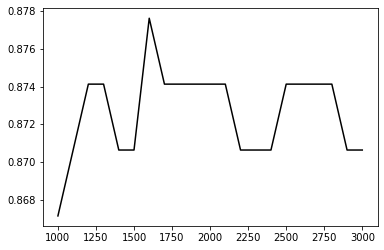

In [ ]:
# Use Support Vector Regressor to fit the data

# C : Regularization parameter. The strength of the regularization is inversely proportional to C.
c_list = [i*100 for i in range(10,31)]
svc_conf_list = []
for c in c_list:
    # gamma : Kernel coefficient
    gamma = 0.00001

    # radial basis function kernel
    kernel="rbf"

    svc = SVC(kernel=kernel, C=c, gamma=gamma)
    svc.fit(new_train_X_5, new_action_train_y)

    svc_prediction = svc.predict(new_valid_X_5)
    svc_confidence = svc.score(new_valid_X_5, new_action_valid_y)
    print("svc confidence (c =", c,"):", svc_confidence)
    svc_conf_list.append(svc_confidence)
    
plt.plot(c_list, svc_conf_list, label = "C to SVC Confid", color = 'Black')

In [ ]:
# Choose C = 1600

svc confidence (gamma = 1e-07 ): 0.7482517482517482
svc confidence (gamma = 5e-07 ): 0.8181818181818182
svc confidence (gamma = 1e-06 ): 0.8321678321678322
svc confidence (gamma = 5e-06 ): 0.8601398601398601
svc confidence (gamma = 1e-05 ): 0.8776223776223776
svc confidence (gamma = 5e-05 ): 0.8811188811188811
svc confidence (gamma = 0.0001 ): 0.8706293706293706
svc confidence (gamma = 0.0005 ): 0.8426573426573427


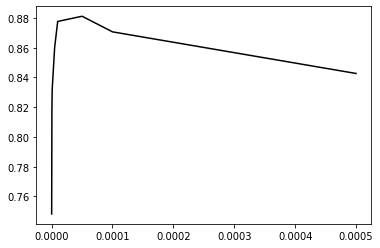

In [ ]:
# Use Support Vector Regressor to fit the data

# gamma : Kernel coefficient

gamma_list = [0.0000001,0.0000005,0.000001,0.000005,0.00001,0.00005,0.0001,0.0005]
svc_conf_list = []
for gamma in gamma_list:
    # C : Regularization parameter. The strength of the regularization is inversely proportional to C.
    c = 1600

    # radial basis function kernel
    kernel="rbf"

    svc = SVC(kernel=kernel, C=c, gamma=gamma)
    svc.fit(new_train_X_5, new_action_train_y)

    svc_prediction = svc.predict(new_valid_X_5)
    svc_confidence = svc.score(new_valid_X_5, new_action_valid_y)
    print("svc confidence (gamma =", gamma,"):", svc_confidence)
    svc_conf_list.append(svc_confidence)
    
plt.plot(gamma_list, svc_conf_list, label = "gamma to SVC Confid", color = 'Black')

In [ ]:
# Choose gamma = 0.00005

# Model Testing

In [ ]:
# C : Regularization parameter. The strength of the regularization is inversely proportional to C.
c = 1600

# gamma : Kernel coefficient
gamma = 0.00005

# radial basis function kernel
kernel="rbf"

svc = SVC(kernel=kernel, C=c, gamma=gamma)
svc.fit(new_train_X_5, new_action_train_y)

svc_prediction = svc.predict(new_test_X_5)
svc_confidence = svc.score(new_test_X_5, new_action_test_y)
print("svc confidence:", svc_confidence)


svc confidence: 0.875751503006012


# Model Export


In [ ]:
with open("model/svc_"+str(num_day_to_predict)+"day.pickle", "wb") as f:
    pickle.dump(svc, f)